In [1]:
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
import os
import unicodedata
import pickle
from pprint import pprint

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_parquet('./data/spiderwebv4_dataset_html/')

In [3]:
df.head()

,url,html_str,ecommerce
0,http://zenirmoveis.com.br,"\n<!DOCTYPE html>\n <html lang=""pt-BR"">\n <h...",1
1,https://www.lojacitron.com.br,"<!DOCTYPE html >\r\n<html xmlns=""http://www.w3...",1
2,http://www.casafreitas.com.br,"<!DOCTYPE html >\r\n<html xmlns=""http://www.w3...",1
3,http://www.lojacaos.com.br,"\n<!DOCTYPE html>\n <html lang=""pt-BR"">\n <h...",1
4,https://www.modab.com.br,"<!doctype html><html class=""no-js"" lang=""pt-BR...",1


In [4]:
df['ecommerce'].value_counts()

ecommerce
0    1110
1     896
Name: count, dtype: int64

In [5]:
len(df)

2006

In [6]:
# Carregar dados
def load_data(path):
    try:
        df = pd.read_parquet(path)
        htmls = []
        labels = []
        domains = []

        for index, row in df.iterrows():
            htmls.append(row['html_str'])
            labels.append(row['ecommerce'])
            domains.append(row['url'])

    except Exception as e:
        print('Failed to load data. Error: ' + str(e))

    return htmls, labels, domains

In [7]:
# Pre processamento
STOP_WORDS = (set(stopwords.words('portuguese'))).union(set(stopwords.words('english')))
lemmatizer = WordNetLemmatizer()

def custom_tokenizer(html_text):
    try:
        # pegar somente o body do HTML
        soup = BeautifulSoup(html_text, "html.parser")
        text = soup.body.get_text() if soup.body else ""

        # pre processamento do texto
        # normalizar
        preprocessed_text = unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("utf-8")

        # lowercase
        preprocessed_text = preprocessed_text.lower()

        # substitui tudo que não é letra ou espaço por um espaço
        preprocessed_text = re.sub(r"[^a-zA-Z\s]", " ", preprocessed_text)

        # remover possives espaços repetidos
        preprocessed_text = re.sub(r"\s+", " ", preprocessed_text).strip()
  
        # tokenizar
        tokens = nltk.word_tokenize(preprocessed_text)

        # remover stopwords
        tokens = [
            token for token in tokens if token not in STOP_WORDS and len(token) > 2
        ]
        
        # Aplicar lemmatizer
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        return tokens

    except Exception as e:
        print(e)
        print("Failed on custom_tokenizer, passing...")
        return []

In [ ]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

# df = pd.read_parquet('./data/spiderwebv4_dataset_html/')
htmls, labels, domains = load_data('./data/spiderwebv4_dataset_html/')

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/darrazao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/darrazao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/darrazao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
# processed_htmls = []
# processed_labels = []

# accounting_texts = []
# non_accounting_texts = []

# for html, label in tqdm(zip(htmls, labels), total=len(htmls)):
#     try:
#         # preprocessamento e tokenizar
#         tokens = custom_tokenizer(html)

#         # Juntar em texto corrido
#         preprocessed_text = " ".join(tokens)

#         # Armazena resultados dos processamentos
#         processed_htmls.append(preprocessed_text)
#         processed_labels.append(label)

#         if label == 1:
#             accounting_texts.append(preprocessed_text)
#         if label == 0:
#             non_accounting_texts.append(preprocessed_text)

#         # para verificar erro de ortografia encontrado
#         # if 'credibilidadeem' in preprocessed_text: #'onlinequalquer'
#         #     soup = BeautifulSoup(html, "html.parser")
#         #     print(soup.body.get_text() if soup.body else "")
                
#     except Exception as e:
#         print(e)
#         print("passing..")
#         continue

# # Gerar wordcloud dos documentos de contabilidade / não contabilidade
# text_combined = " ".join(accounting_texts)
# non_text_combined = " ".join(non_accounting_texts)

# wordcloud = WordCloud(width=800, height=400).generate(text_combined)

# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.savefig("report/is_ecomm.png")

# wordcloud = WordCloud(width=800, height=400).generate(non_text_combined)

# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.savefig("report/isnot_ecomm.png")

In [10]:
# report pros modelos
def model_report(confusion_matrix, classification_report, model_card):
    
    # Gera o heatmap da confusion matrix
    plt.figure(figsize=(5,5))
    sns.heatmap(confusion_matrix, 
                annot=True, 
                fmt="d", 
                linewidths=.5, 
                square = True, 
                cmap = 'Blues', 
                annot_kws={"size": 16}, 
                xticklabels=['non_acc', 'acc'], 
                yticklabels=['non_acc', 'acc'])

    plt.xticks(rotation='horizontal', fontsize=16)
    plt.yticks(rotation='horizontal', fontsize=16)
    plt.xlabel('Predicted Label', size=20)
    plt.ylabel('Actual Label', size=20)

    title = 'Accuracy Score: {0:.4f}'.format(classification_report['accuracy'])
    plt.title(title, size = 20)

    # Mostra o classification report e o heatmap
    pprint(classification_report)
    plt.show()

    model_card['accuracy_best'] = round(classification_report['accuracy'], 4)
    model_card['precision_macro_best'] = round(classification_report['macro avg']['precision'], 4)
    model_card['recall_macro_best'] = round(classification_report['macro avg']['recall'], 4)
    model_card['f1_macro_best'] = round(classification_report['macro avg']['f1-score'], 4)
    model_card['support_0_best'] = classification_report['0']['support']
    model_card['support_1_best'] = classification_report['1']['support']

    return model_card

In [11]:
def save_vectorizer_model(vectorizer, model, model_card):
    try:
        file_name = model_card['vectorizer'] + '_' + model_card['model'] + '_' + \
            str(model_card['word_reduction']) + '_' + str(model_card['kfold_splits']) + '_' + str(model_card['kfold_shuffle']) + '_' + \
                str(model_card['kfold_random_state']) + '_' + str(model_card['vectorizer_max_features']) + '_' + model_card['dataset']

        model_card['vectorizer_file_name'] = 'BEST_VECTORIZER_' + file_name + '.pkl'
        model_card['model_file_name'] = 'BEST_MODEL_' + file_name + '.pkl'

        with open('models/' + model_card['vectorizer_file_name'], 'wb') as file:
            pickle.dump(vectorizer, file)
        with open('models/' + model_card['model_file_name'], 'wb') as file:
            pickle.dump(model, file)

    except Exception as e:
        print('An error ocurred while trying to save the model. Error: ' + str(e))
        print(model_card)

    return model_card

In [12]:
# Dados do modelo
model_card = {
    'vectorizer': '',
    'model': '',
    'word_reduction': 'lemmatizer',
    'kfold_splits': 3,
    'kfold_shuffle': True,
    'kfold_random_state': 42,
    'vectorizer_max_features': 1000,
    'dataset': 'ecomm_spiderwebv4_dataset_html', 
    'accuracy_best': '',
    'precision_macro_best': '',
    'recall_macro_best': '',
    'f1_macro_best': '',
    'support_0_best': '',
    'support_1_best': '',
    'vectorizer_file_name': '',
    'model_file_name': ''
}

# metricas utilizadas pela validação cruzada
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score, normalize=True), 
    'precision': make_scorer(precision_score, average='macro', zero_division=0), 
    'recall': make_scorer(recall_score, average='macro'), 
    'f1': make_scorer(f1_score, average='macro')
    }

In [13]:
def predict_proba_with_domain(X_raw: list, estimator, vectorizer):

    test_tfid_X = vectorizer.transform(X_raw)
    model_predictions_prob = estimator.predict_proba(test_tfid_X)

    y_probs_0 = []
    y_probs_1 = []
    y_preds = []

    for prob_tuple in model_predictions_prob:
        y_probs_0.append(prob_tuple[0])
        y_probs_1.append(prob_tuple[1])

        if prob_tuple[1] >= 0.5:
            y_preds.append(1)
        else:
            y_preds.append(0)

    return y_preds, y_probs_0, y_probs_1

splitting
starting...
starting 2...


starting 3...
reporting...
reporting 2...
reporting 3...
reporting 4...
{'0': {'f1-score': 0.9121338912133892,
       'precision': 0.872,
       'recall': 0.956140350877193,
       'support': 228.0},
 '1': {'f1-score': 0.8711656441717791,
       'precision': 0.9342105263157895,
       'recall': 0.8160919540229885,
       'support': 174.0},
 'accuracy': 0.8955223880597015,
 'macro avg': {'f1-score': 0.8916497676925841,
               'precision': 0.9031052631578947,
               'recall': 0.8861161524500907,
               'support': 402.0},
 'weighted avg': {'f1-score': 0.8944013663744832,
                  'precision': 0.8989269442262372,
                  'recall': 0.8955223880597015,
                  'support': 402.0}}


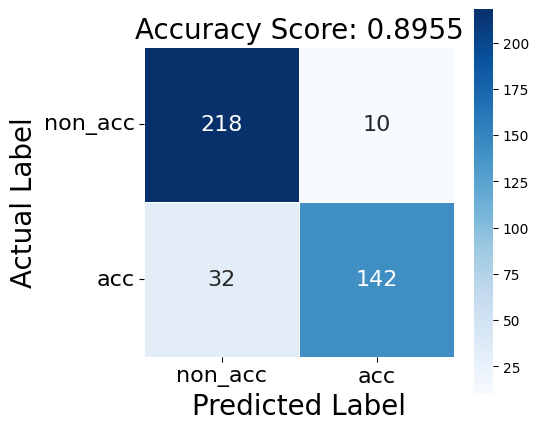

{'vectorizer': 'ecomm_tfidf_vectorizer', 'model': 'ecomm_logistic_regression_lbfgs', 'word_reduction': 'lemmatizer', 'kfold_splits': 3, 'kfold_shuffle': True, 'kfold_random_state': 42, 'vectorizer_max_features': 1000, 'dataset': 'ecomm_spiderwebv4_dataset_html', 'accuracy_best': 0.8955, 'precision_macro_best': 0.9031, 'recall_macro_best': 0.8861, 'f1_macro_best': 0.8916, 'support_0_best': 228.0, 'support_1_best': 174.0, 'vectorizer_file_name': '', 'model_file_name': ''}


In [ ]:
# Logistic Regression com TF-IDF

# htmls, labels, domains = load_data('./data/spiderwebv4_dataset_html/')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('splitting')
htmls_train, htmls_test, labels_train, labels_test, domains_train, domains_test = train_test_split(htmls, labels, domains, test_size=0.2, random_state=42)

lgrg_tfidf_model_card = model_card.copy()
lgrg_tfidf_model_card['vectorizer'] = 'ecomm_tfidf_vectorizer'
lgrg_tfidf_model_card['model'] = 'ecomm_logistic_regression_lbfgs'

print('starting...')
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None, max_features=model_card['vectorizer_max_features'])
# tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None, max_features=500)
print('starting 2...')
train_tfidf_X = tfidf_vectorizer.fit_transform(htmls_train)
print('starting 3...')
lgrg_tfidf = LogisticRegression(solver='lbfgs').fit(X=train_tfidf_X, y=labels_train)

######################################################################################################
# best model report
print('reporting...')
y_preds, y_probs_0, y_probs_1 = predict_proba_with_domain(htmls_test, lgrg_tfidf, tfidf_vectorizer)
print('reporting 2...')
model_cmatrix = confusion_matrix(y_pred=y_preds, y_true=labels_test)
print('reporting 3...')
model_creport = classification_report(y_pred=y_preds, y_true=labels_test, zero_division=0, output_dict=True)
print('reporting 4...')
lgrg_tfidf_model_card = model_report(model_cmatrix, model_creport, lgrg_tfidf_model_card)
print(lgrg_tfidf_model_card) #0.8955223880597015
#######################################################################################################

In [15]:
print(classification_report(y_pred=y_preds, y_true=labels_test, zero_division=0, output_dict=False))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       228
           1       0.93      0.82      0.87       174

    accuracy                           0.90       402
   macro avg       0.90      0.89      0.89       402
weighted avg       0.90      0.90      0.89       402



starting...
starting 2...


starting 3...
reporting...
reporting 2...
reporting 3...
reporting 4...
{'0': {'f1-score': 0.9260700389105059,
       'precision': 0.8902743142144638,
       'recall': 0.9648648648648649,
       'support': 1110.0},
 '1': {'f1-score': 0.8993525603296056,
       'precision': 0.9514321295143213,
       'recall': 0.8526785714285714,
       'support': 896.0},
 'accuracy': 0.9147557328015952,
 'macro avg': {'f1-score': 0.9127112996200557,
               'precision': 0.9208532218643926,
               'recall': 0.9087717181467181,
               'support': 2006.0},
 'weighted avg': {'f1-score': 0.9141364093948096,
                  'precision': 0.9175910652157959,
                  'recall': 0.9147557328015952,
                  'support': 2006.0}}


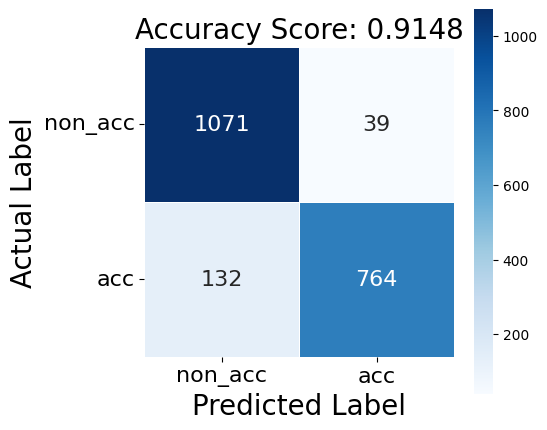

{'vectorizer': 'ecomm_tfidf_vectorizer', 'model': 'ecomm_logistic_regression_lbfgs', 'word_reduction': 'lemmatizer', 'kfold_splits': 3, 'kfold_shuffle': True, 'kfold_random_state': 42, 'vectorizer_max_features': 1000, 'dataset': 'ecomm_spiderwebv4_dataset_html', 'accuracy_best': 0.9148, 'precision_macro_best': 0.9209, 'recall_macro_best': 0.9088, 'f1_macro_best': 0.9127, 'support_0_best': 1110.0, 'support_1_best': 896.0, 'vectorizer_file_name': '', 'model_file_name': ''}


In [16]:
# train full model 
lgrg_tfidf_model_card = model_card.copy()
lgrg_tfidf_model_card['vectorizer'] = 'ecomm_tfidf_vectorizer'
lgrg_tfidf_model_card['model'] = 'ecomm_logistic_regression_lbfgs'

print('starting...')
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None, max_features=model_card['vectorizer_max_features'])
print('starting 2...')
train_tfidf_X = tfidf_vectorizer.fit_transform(htmls)
print('starting 3...')
lgrg_tfidf = LogisticRegression(solver='lbfgs').fit(X=train_tfidf_X, y=labels)

######################################################################################################
# best model report
print('reporting...')
y_preds, y_probs_0, y_probs_1 = predict_proba_with_domain(htmls, lgrg_tfidf, tfidf_vectorizer)
print('reporting 2...')
model_cmatrix = confusion_matrix(y_pred=y_preds, y_true=labels)
print('reporting 3...')
model_creport = classification_report(y_pred=y_preds, y_true=labels, zero_division=0, output_dict=True)
print('reporting 4...')
lgrg_tfidf_model_card = model_report(model_cmatrix, model_creport, lgrg_tfidf_model_card)
print(lgrg_tfidf_model_card) #
#######################################################################################################
# save model
lgrg_tfidf_model_card = save_vectorizer_model(tfidf_vectorizer, lgrg_tfidf, lgrg_tfidf_model_card)

In [17]:
print(asd)

NameError: name 'asd' is not defined

In [ ]:
# Carregar dados de teste e salvar a prediction e a probability
df_test = pd.read_parquet('./data/validated_accounting_websites_test.parquet')
df_test.head(2)

,website,is_accounting,html,text
0,museudoautomovelsp.com.br,0,<!DOCTYPE html>\n<!--[if lt IE 7]> <html class...,CARROSANTIGOSORG 520 WEB SERVER IS RETURNING ...
1,molantmarcas.com.br,0,<!DOCTYPE html>\r\n<!--[if IE 7 ]><html class=...,REGISTRO DE MARCASMARCAS E PATENTESREGISTRAR U...


In [ ]:
# ROC curve
fpr, tpr, thresholds = roc_curve(df_test['is_accounting'], y_probs_1, drop_intermediate=True)
pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})

,fpr,tpr,thresholds
0,0.00,0.00,inf
1,0.00,0.02,0.965377
2,0.00,0.96,0.534675
3,0.04,0.96,0.466565
4,0.04,0.98,0.365192
5,0.32,0.98,0.276796
6,0.32,1.00,0.275602
7,1.00,1.00,0.090965


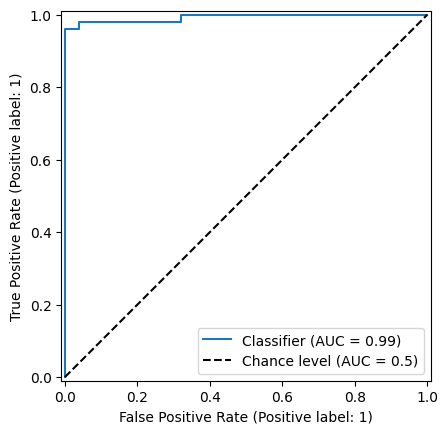

In [ ]:
roc_display = RocCurveDisplay.from_predictions(df_test['is_accounting'], y_probs_1, plot_chance_level=True, drop_intermediate=True)

In [ ]:
def apply_prediction_probabilites(x):
    y_preds, y_probs_0, y_probs_1 = predict_proba_with_domain([x['html']], [x['website']], lgrg_tfidf, tfidf_vectorizer)
    x['pred_0_prob'] = y_probs_0[0]
    x['pred_1_prob'] = y_probs_1[0]
    x['prediction'] = y_preds[0]

    return x

In [ ]:
df_test = df_test.apply(apply_prediction_probabilites, axis=1)

In [ ]:
df_test.to_parquet('./data/validated_accounting_websites_test_predictions.parquet')

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   website        100 non-null    object 
 1   is_accounting  100 non-null    int64  
 2   html           100 non-null    object 
 3   text           100 non-null    object 
 4   pred_0_prob    100 non-null    float64
 5   pred_1_prob    100 non-null    float64
 6   prediction     100 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 5.6+ KB


In [ ]:
df_test.loc[df_test['is_accounting'] != df_test['prediction']]

,website,is_accounting,html,text,pred_0_prob,pred_1_prob,prediction
29,consultauditores.com.br,0,"<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head>\n...",INICIO CONSULT AUDITORES CURITIBAPR41 3350601...,0.465949,0.534051,1


In [ ]:
html_text = df_test.loc[df_test['is_accounting'] != df_test['prediction']]['html'].iloc[0]
soup = BeautifulSoup(html_text, "html.parser")
text = soup.body.get_text() if soup.body else ""

pprint(text)

('\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 'Curitiba-PR:(41) 3350-6013 | Cascavel-PR: (45) 3220-4800\n'
 'auditoria@consultauditores.com.br\n'
 '\n'
 '\n'
 '\n'
 '\n'
 'Localização\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 'Sobre\n'
 'Serviços\n'
 '\n'
 'Auditoria de Controles Internos e Compliance\n'
 'Auditoria de Demonstrações Financeiras\n'
 'Auditoria Tributária\n'
 'Auditoria Contábil com Procedimentos Pré-Acordados\n'
 'Due Diligence\n'
 'Procedimentos e Relatório de Impairment\n'
 'Relatórios e Avaliação IFRS & US GAAP\n'
 'Revisões Específicas\n'
 '\n'
 '\n'
 'Carreira\n'
 'Contato\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 ' \n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 '\n'
 'Auditoria & Revisão / Audit & Assurance\n'
 'Credibilidade às informações financeiras. Serviços de auditoria específicos '
 'para as necessidades da sua organização.\n'
 '\n'
 'Conta

In [ ]:
df_test.loc[df_test['prediction'] == 1].sort_values(by='pred_1_prob')

,website,is_accounting,html,text,pred_0_prob,pred_1_prob,prediction
79,brancacontabilidade.com.br,1,"<html>\n<head><meta http-equiv=""Content-Type"" ...",BRANCA CONTABILIDADE AV JACIRA REIS 1029EDPROV...,0.724398,0.275602,1
81,liderancacontabilidade.bsb.br,1,"<!DOCTYPE html>\n<html lang=""pt-BR"">\n <hea...",LIDERANCA CONTABILIDADE LIDERANCA ASSESSORIA ...,0.634808,0.365192,1
29,consultauditores.com.br,0,"<!DOCTYPE html>\n<html lang=""pt-BR"">\n<head>\n...",INICIO CONSULT AUDITORES CURITIBAPR41 3350601...,0.465949,0.534051,1
77,contabilidadeparamedicos.com.br,1,"<!DOCTYPE html>\n<html lang=""en"">\n<head>\n \...",FORMALIZACAO DE EMPRESA UNIPESSOAL TOP OF PAG...,0.465325,0.534675,1
82,contabilidadetoassi.com.br,1,"<!DOCTYPE html>\n<html lang=""pt-br"">\n\n<head>...",CONTABILIDADE TOASSI EMPRESA CONTATO HOME SER...,0.400323,0.599677,1
90,consultassessoria.com.br,1,\r\n<!DOCTYPE html>\n<!--[if lt IE 7]><html cl...,CONSULT ASSESSORIA INICIAL A CONSULT SERVICOS ...,0.397966,0.602034,1
93,analiseintegra.com.br,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",ANALISE INTELIGENCIA CONTABIL ANALISE CENTRO ...,0.335962,0.664038,1
56,ebomjesus.com.br,1,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",BOM JESUS CONTABILIDADE E IMOVEIS RUA JOAQUIM...,0.334278,0.665722,1
65,2rd360.com.br,1,"<!DOCTYPE html>\n<html lang=""pt"">\n<head>\n \...",2RD360 CONSULTORIA EMPRESARIAL BRASIL TOP OF...,0.296164,0.703836,1
83,cencap-pb.com.br,1,"<!doctype html>\n<html class=""no-js"" lang=""pt-...",CENCAP AREA RESTRITA INICIO EMPRESA CLIENTES S...,0.272097,0.727903,1
